In [146]:
## system
import os

## Math and dataFrame
import numpy as np
import pandas as pd
import scipy
from scipy.sparse import csr_matrix, hstack

## Visualization
%matplotlib inline
import matplotlib.pyplot as plt
from IPython.display import display
import seaborn as sns

In [147]:
## Traditional Machine Learning
from sklearn.linear_model import Ridge, LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import LabelBinarizer

In [148]:
## Keras
from keras.layers import Input, Dropout, Dense, BatchNormalization, Activation, concatenate, GRU
from keras.layers import Embedding, Flatten, Conv1D, Conv2D, LSTM
from keras.models import Model, Sequential
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping#, TensorBoard
from keras import backend as K
from keras import optimizers
from keras.optimizers import SGD
from keras import initializers
from keras.callbacks import LearningRateScheduler
from keras.utils import np_utils
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer

In [149]:
## Nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
import string
from gensim.models import Word2Vec

In [150]:
### Load data
train = pd.read_csv('../data/train_processed.csv')
display(train[:5])

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,explanation why the edits made under my userna...,0,0,0,0,0,0
1,000103f0d9cfb60f,d aww he matches this background colour i m se...,0,0,0,0,0,0
2,000113f07ec002fd,hey man i m really not trying to edit war it s...,0,0,0,0,0,0
3,0001b41b1c6bb37e,more i can t make any real suggestions on imp...,0,0,0,0,0,0
4,0001d958c54c6e35,you sir are my hero any chance you remember wh...,0,0,0,0,0,0


###### This we use Embedding instead of using pretrained models

In [151]:
#PROCESS TEXT: RAW
print("Text to seq process...")
print("   Fitting tokenizer...")
raw_text = train.comment_text.values
tok_raw = Tokenizer()
tok_raw.fit_on_texts(raw_text)
print("   Transforming text to seq...")
train["input"] = tok_raw.texts_to_sequences(train.comment_text.values)

Text to seq process...
   Fitting tokenizer...
   Transforming text to seq...


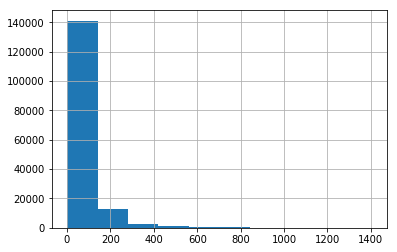

In [152]:
train.input.apply(lambda x: len(x)).hist()

In [153]:
MAX_LENGTH = 150
MAX_TOKEN = np.max(train.input.max()) + 5
print(MAX_LENGTH, MAX_TOKEN)

(150, 178646)


In [154]:
train = train[['input', TARGET]]
dtrain, dvalid = train_test_split(train, random_state=17, train_size=0.7)
print(dtrain.shape)
print(dvalid.shape)

(111699, 2)
(47872, 2)


### Resampling

In [155]:
L = len(dtrain)
df_irr = dtrain[dtrain.toxic != 0]
while len(dtrain) < 2*L:
    dtrain = dtrain.append(df_irr, ignore_index=True)

In [156]:
L = len(dvalid)
df_irr = dvalid[dvalid.toxic != 0]
while len(dvalid) < 2*L:
    dvalid = dvalid.append(df_irr, ignore_index=True)

###### Creating RNN model

In [157]:
A = Input(shape=(MAX_LENGTH,), name="in")
tmp = A
tmp = Embedding(MAX_TOKEN, 256)(tmp)
tmp = GRU(64) (tmp)
tmp = Dropout(0.25) (Dense(128, activation='relu') (tmp))
tmp = Dropout(0.5) (Dense(32, activation='relu') (tmp))
output = Dense(2, activation="softmax") (tmp)

In [158]:
model = Model(A, output)
N_epoch = 10
learning_rate = 0.05
optimizer = SGD(learning_rate)
loss = 'categorical_crossentropy'
metrics = ['accuracy']
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
in (InputLayer)              (None, 150)               0         
_________________________________________________________________
embedding_6 (Embedding)      (None, 150, 256)          45733376  
_________________________________________________________________
gru_2 (GRU)                  (None, 64)                61632     
_________________________________________________________________
dense_13 (Dense)             (None, 128)               8320      
_________________________________________________________________
dropout_9 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_14 (Dense)             (None, 32)                4128      
_________________________________________________________________
dropout_10 (Dropout)         (None, 32)                0         
__________

In [ ]:
train_x = pad_sequences(dtrain.input, maxlen=MAX_LENGTH)
valid_x = pad_sequences(dvalid.input, maxlen=MAX_LENGTH)
train_y = np_utils.to_categorical(dtrain.toxic.values, 2)
valid_y = np_utils.to_categorical(dvalid.toxic.values, 2)

In [ ]:
res = model.fit(train_x, train_y, batch_size = 128, epochs = N_epoch, 
                verbose = 1, validation_data = (valid_x, valid_y))

Train on 229509 samples, validate on 98296 samples
Epoch 1/10
229509/229509 [==============================] - 423s - loss: 0.3857 - acc: 0.8375 - val_loss: 0.4532 - val_acc: 0.8000
Epoch 3/10
229509/229509 [==============================] - 427s - loss: 0.3834 - acc: 0.8335 - val_loss: 1.0449 - val_acc: 0.5930
Epoch 4/10
229509/229509 [==============================] - 436s - loss: 0.3400 - acc: 0.8610 - val_loss: 0.7022 - val_acc: 0.6122
Epoch 5/10
229509/229509 [==============================] - 466s - loss: 0.2582 - acc: 0.8961 - val_loss: 0.2452 - val_acc: 0.9107
Epoch 6/10
229509/229509 [==============================] - 432s - loss: 0.1656 - acc: 0.9397 - val_loss: 0.4412 - val_acc: 0.8878
Epoch 7/10
229509/229509 [==============================] - 430s - loss: 0.1401 - acc: 0.9495 - val_loss: 0.3141 - val_acc: 0.9102
Epoch 8/10
229509/229509 [==============================] - 429s - loss: 0.1231 - acc: 0.9570 - val_loss: 0.3675 - val_acc: 0.9081
Epoch 9/10
229509/229509 [======

In [ ]:
from pprint import pprint